# Retrieval-Augmented Generation with Gemma hosted on HuggingFace and Weaviate in DSPy

This Notebook shows you the basic steps to build a minimal Retrieval-Augmented Generation (RAG) pipeline using the following building blocks:
* Google's open source large language model (LLM), [Gemma](https://www.kaggle.com/models/google/gemma) model hosted on [Hugging Face](https://huggingface.co/).
* [Hugging Face](https://huggingface.co/)'s open source[`sentence-transformers/all-MiniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model.
* [Weaviate](weaviate.io)'s open source vector datbase for external context.
* [DSPy](https://github.com/stanfordnlp/dspy) for orchestration.

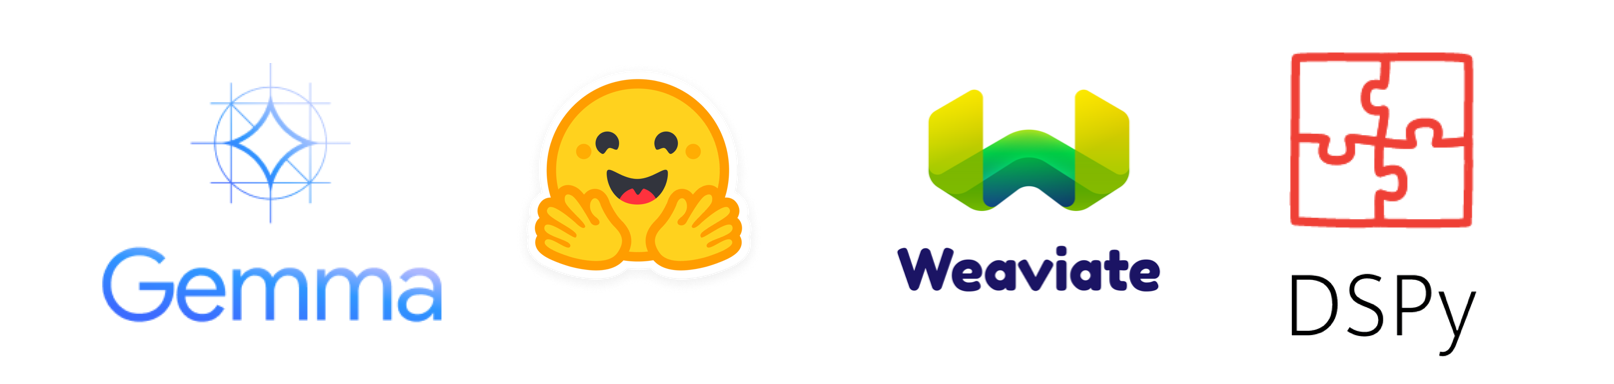

# What is Retrieval-Augmented Generation?

**Retrieval-Augmented Generation (RAG)** is technique proposed Lewis et al. in 2020 [1] to provide LLMs with additional contenxt to reduce hallcinations and increase accuracy, similarly to traditional fine-tuning.

Below, you can see the fundamental workflow of a naive RAG pipeline:
1. **Retrieval:** The user's query is used to retrieve additional context from an external knowledge source. The external knowledge source stores pieces of information and their vector embeddings. At query time, the user query is embedded into the same vector space and used to retrieve similar context by calculating the closest data points.
2. **Augmentation:** The user query and retrieved additional context are then used to augment a prompt template.
3. **Generation:** The augmented prompt is used to generate a more factually accurate answer than the user query alone.

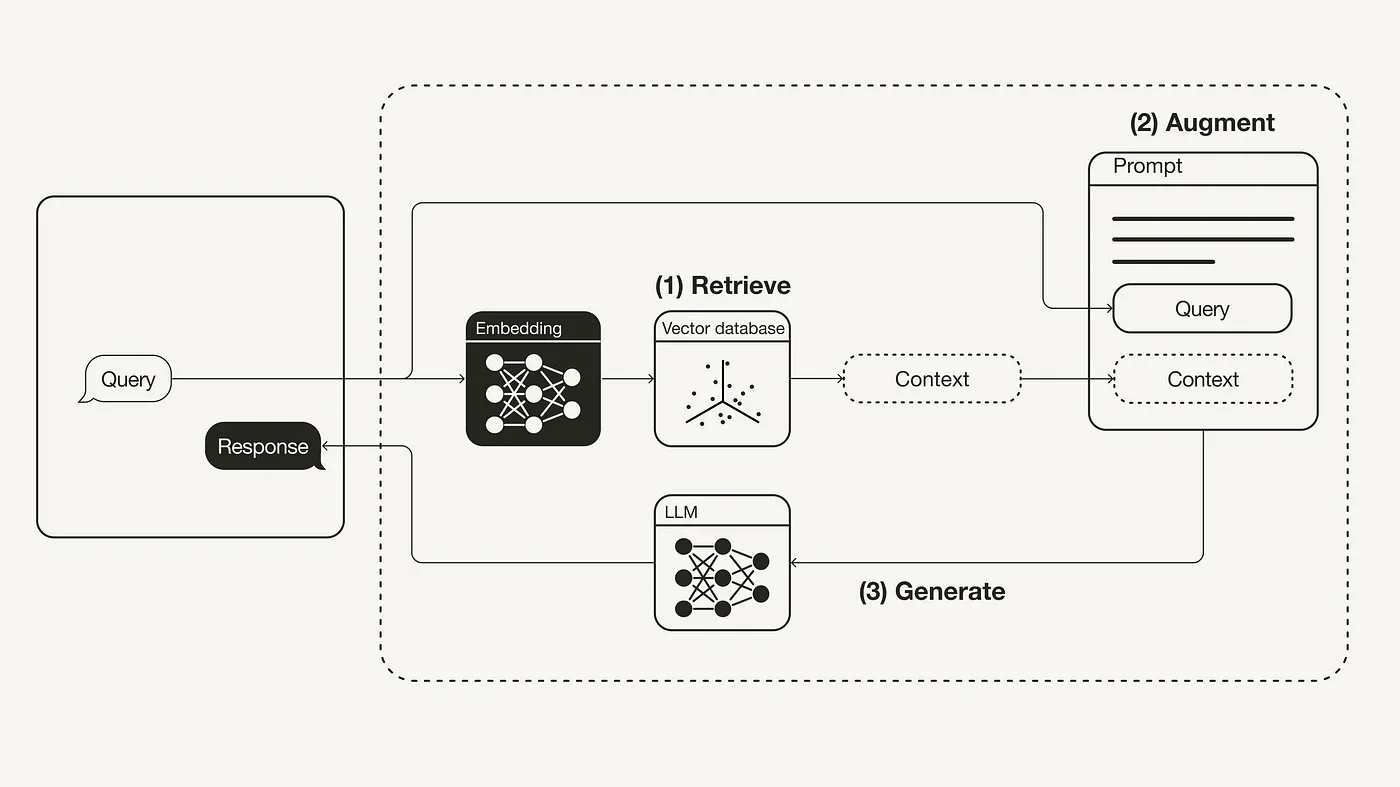

*(Image by the author, [Leonie](https://www.kaggle.com/iamleonie), originally published in [Retrieval-Augmented Generation (RAG): From Theory to LangChain Implementation](https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2))*

# What is DSPy?

[DSPy](https://github.com/stanfordnlp/dspy) [2] is a framework that helps developers build pipelines using language models (LMs) like Gemma, similar to [LangChain](https://www.langchain.com/) or [LlamaIndex](https://www.llamaindex.ai/). 

However, currently developing LM-based systems can be brittle: For example, if you change the used LLM, you will most likely face performance losses if you don't also adapt the prompt. DSPy aims to solve this issue by enabling developers to "recompile" their program after changing components in their program, which will optimize the internal parameters.

DSPy introduces *signatures* and *modules* to enable developers to define LM-based programs similarly to neural network architectures in PyTorch. After you have defined your DSPy program, you can use some sample data, an optimizer (called *teleprompter* in DSPy), a metric, and a DSPy compiler to optimize your DSPy program, similarly to how you would train a neural network with training data, an optimizer, and a metric.

For a more detailed introduction to DSPy you can read my latest blog post outlining its concepts here: [Intro to DSPy: Goodbye Prompting, Hello Programming!](https://medium.com/towards-data-science/intro-to-dspy-goodbye-prompting-hello-programming-4ca1c6ce3eb9?sk=9c65441028a96a8f7e8eac9ed6ba4347) 

# Prerequisites

To follow this tutorial, you will need to fulfill the following prerequisites:
1. Enable GPU in the Notebook
2. Install the following packages:

In [1]:
!pip install -U transformers
!pip install dspy-ai
!pip install weaviate-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.0
    Uninstalling transformers-4.37.0:
      Successfully uninstalled transformers-4.37.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.12.2
    Uninstalling fsspec-2023.12.2:
      Successfully uninstalled fsspec-2023.12.2
  Attempting uninstall

3. [Request access to the Gemma model family on Hugging Face](https://huggingface.co/google/gemma-7b-it) to be able to use Gemma via DSPy.
4. Set your Hugging Face token and your OpenAI API key in the Kaggle secrets: You will need to have an Hugging Face API key (Gemma can be used for free without a Pro account). To obtain a Hugging Face API key, you will need to register with Hugging Face and then create a token under your profile via *Settings > Access tokens*. Use Kaggle secrets to use your Hugging Face API key in this Kaggle Notebook without sharing it with others. (Adds-ons > Secrets)

In [2]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_API_KEY")

# Login to Hugging Face
login(hf_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Step 1: Load Data

In this Notebook, we will use the title and the descriptions of the last 100 featured Kaggle competitions from the [Meta Kaggle dataset](https://www.kaggle.com/datasets/kaggle/meta-kaggle), as this will require no data processing, such as chunking, so we can focus on the overall flow of the RAG technique in DSPy.

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/kaggle/input/meta-kaggle/Competitions.csv")

# Let's only index 100 data points for this example
df = df[(df.HostSegmentTitle == "Featured") & (df.Subtitle.notna())][-100:]
df[['Title', 'Subtitle']].head()

,Title,Subtitle
1030,RSNA Pneumonia Detection Challenge,Can you build an algorithm that automatically detects potential pneumonia cases?
1036,PLAsTiCC Astronomical Classification,Can you help make sense of the Universe?
1037,Santander Customer Transaction Prediction,Can you identify who will make a transaction?
1043,Human Protein Atlas Image Classification,Classify subcellular protein patterns in human cells
1045,Elo Merchant Category Recommendation,Help understand customer loyalty


# Step 2: Populate Vector Database

Next, you will need to define a **retriever model (RM)**. I will be using [Weaviate](weaviate.io), an [open source vector database](https://github.com/weaviate/weaviate), for this.

As this Notebook is intended to show case a simple walk through, we will be using [Weaviate embedded](https://weaviate.io/developers/weaviate/installation/embedded), which is a local instance inside the lifecycle of the Notebook and doesn't require any registration for an API key and free to use. 

**Disclaimer:** At the time of writing I am a Developer Advocate at Weaviate.

Before populating the vector database, you will need to define the schema of your data collection. DSPy expects a property field named `"content"` to use Weaviate as RM. Additionally, we will define a vectorizer module, which is an embedding model that automatically generates the vector embeddings of the data at import and query time. We will configure [`sentence-transformers/all-MiniLM-L6-v2` from Hugging Face](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) for this.

In [4]:
import weaviate
from weaviate.embedded import EmbeddedOptions
import re

# Connect to Weaviate client in embedded mode
client = weaviate.Client(embedded_options=EmbeddedOptions(),
                             additional_headers={
                                "X-Huggingface-Api-Key": hf_token,
                             }
                         )

# Create Weaviate schema
schema = {
   "classes": [
       {
           "class": "MyExampleIndex",
           "vectorizer": "text2vec-huggingface",
            "moduleConfig": {
                "text2vec-huggingface": {
                    "model": "sentence-transformers/all-MiniLM-L6-v2",
                }
            },
           "properties": [
               {
                   "name": "content", # This is a required property name to be able to use Weaviate as RM with DSPy
                   "dataType": ["text"]
               }
           ]
       }      
   ]
}

# Delete existing data collection if it already exists from a previous run
if client.schema.exists("MyExampleIndex"):
    client.schema.delete_class("MyExampleIndex")
client.schema.create(schema)

# Populate vector database in batches
client.batch.configure(batch_size=100)  # Configure batch (for only 100 data points this is not really necessary...)

with client.batch as batch:  # Initialize a batch process
    for _, row in df.iterrows():
        properties = {
            "content": row['Title'] + ' Kaggle Competition: ' + row['Subtitle']
        }
        batch.add_data_object(
            data_object=properties,
            class_name="MyExampleIndex"
        )

/opt/conda/lib/python3.10/site-packages/weaviate/warnings.py:158: DeprecationWarning: Dep016: You are using the Weaviate v3 client, which is deprecated.
            Consider upgrading to the new and improved v4 client instead!
            See here for usage: https://weaviate.io/developers/weaviate/client-libraries/python
            
  warnings.warn(


Binary /root/.cache/weaviate-embedded did not exist. Downloading binary from https://github.com/weaviate/weaviate/releases/download/v1.23.7/weaviate-v1.23.7-Linux-amd64.tar.gz
Started /root/.cache/weaviate-embedded: process ID 79


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-02-28T11:59:56Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-02-28T11:59:56Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-02-28T11:59:56Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-02-28T11:59:56Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50060","time":"2024-02-28T11:59:56Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"202

Check how many data objects were inserted:

In [5]:
client.query.aggregate("MyExampleIndex").with_meta_count().do()

{'data': {'Aggregate': {'MyExampleIndex': [{'meta': {'count': 100}}]}}}

Retrieve some example data points for sanity check. The method `.with_limit(n)` controls how many data points are retrieved.

In [6]:
import json

response = (
    client.query
    .get("MyExampleIndex", ["content"])
    .with_limit(2)
    .do()
)

print(json.dumps(response, indent=4))

{
    "data": {
        "Get": {
            "MyExampleIndex": [
                {
                    "content": "Google Cloud & NCAA\u00ae ML Competition 2020-NCAAW Kaggle Competition: Apply Machine Learning to NCAA\u00ae March Madness\u00ae"
                },
                {
                    "content": "Kore 2022 Kaggle Competition: Use a fleet of spaceships to mine minerals before your opponents"
                }
            ]
        }
    }
}


Let's run an example vector search/similarity search query. The query is defined as the value for the `"concepts"` key in the `.with_near_text()` method.

In [7]:
response = (
    client.query
    .get("MyExampleIndex", ["content"])
    .with_near_text({"concepts": ["Medical"]})
    .with_limit(3)
    .do()
)

print(json.dumps(response, indent=4))

{
    "data": {
        "Get": {
            "MyExampleIndex": [
                {
                    "content": "RANZCR CLiP - Catheter and Line Position Challenge Kaggle Competition: Classify the presence and correct placement of tubes on chest x-rays to save lives"
                },
                {
                    "content": "NBME - Score Clinical Patient Notes Kaggle Competition: Identify Key Phrases in Patient Notes from Medical Licensing Exams"
                },
                {
                    "content": "SIIM-ACR Pneumothorax Segmentation Kaggle Competition: Identify Pneumothorax disease in chest x-rays"
                }
            ]
        }
    }
}


# Step 3: Configure DSPy Settings
Next, you will configure the language model (LM) and the retriever model (RM) in the global settings for DSPy.

In [8]:
import dspy

/opt/conda/lib/python3.10/site-packages/dsp/modules/gpt3.py:5: ResourceWarning: unclosed file <_io.TextIOWrapper name='/kaggle/working/openai_usage.log' mode='a' encoding='UTF-8'>
  logging.basicConfig(


## Language Model: Google Gemma

There are currently four versions of [Gemma](https://www.kaggle.com/models/google/gemma) available:
* `gemma_2b_en`
* `gemma_7b_en`
* `gemma_instruct_2b_en`
* `gemma_instruct_7b_en`

The `2b` and `7b` variants can be differentiated by their [intended platforms](https://ai.google.dev/gemma/docs):
* `2b`: Intended platforms are mobile devices and laptops
* `7b`: Intended platforms are desktop computers and small servers

The pretrained and instruction tuned variants can be differentiated by [their training](https://ai.google.dev/gemma/docs):
* **Pretrained:** not trained on any specific tasks. It is not recommended to deploy these models without additional tuning.
* **Instruction tuned:** trained with human language interactions and can respond to conversational input, similar to a chat bot.

In [9]:
# Configure language model
llm = dspy.HFModel(model = 'google/gemma-2b')

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Let's invoke Gemma with a sample query:

In [10]:
example_query = "Which Kaggle competition should I look at to learn more about recommender systems in e-commerce?"

#"Which Kaggle competition should I look at to learn more about recommender systems in e-commerce?"
#"You might be interested in the H&M Personalized Fashion Recommendations or Elo Merchant Category Recommendation Kaggle Competition competition,"

response = llm(example_query)

print(response)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
2024-02-28 12:00:43.933223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 12:00:43.933323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 12:00:44.177095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['Which Kaggle competition should I look at to learn more about recommender systems in e-commerce?\n\nI am a beginner in recommender systems and I am looking for a competition that I can learn from.\n\nI am looking for a competition that is not too difficult, but also not too easy.\n\nI am looking for a competition that is not too difficult, but also not too easy.\n\nI am looking for a competition that is not too difficult, but also not too easy.\n\nI am looking for a competition that is not too difficult, but also not too easy.\n\nI am looking for a competition that is not too difficult, but also not too easy.\n\nI am looking for a competition that is not too difficult, but also not too easy.\n\nI am looking for a competition that is not too difficult, but']


It seems like Gemma isn't able to answer the example query without any additional context. This is why, we will implement a RAG pipeline in the following code.

## Retriever Model: Weaviate
Next, you will need to configure your Weaviate instance from earlier in the `WeaviateRM` retriever model from DSPy.

In [11]:
from dspy.retrieve.weaviate_rm import WeaviateRM

# Configure retriever model
rm = WeaviateRM("MyExampleIndex", 
                weaviate_client = client)

Now, configure the LM and the RM in the overall DSPy settings.

In [12]:
# Configure DSPy to use the following language model and retrieval model by default
dspy.settings.configure(lm = llm, 
                        rm = rm)

# Step 4: Write DSPy Program

Now, we can write a simple DSPy program for our RAG pipeline.

This is similar to defining a neural network architecture in PyTorch:
* In the `__init__()` method define your modules. We will use a `Retrieve` module to retrieve additional context from the vector database and a `ChainOfThought` module to prompt Gemma with a chain of thought ("Let's think step by step") prompting technique
* In the `forward()` method, you will define the flow of information among the defined modules.

In [13]:
class RAG(dspy.Module):
    def __init__(self, num_passages=3):
        super().__init__()

        self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_answer = dspy.ChainOfThought("context, question -> answer")
    
    def forward(self, question):
        context = self.retrieve(question).passages
        prediction = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=prediction.answer)

The above code will create the following flow of information among the `Retrieve` and the `ChainOfThought` modules.

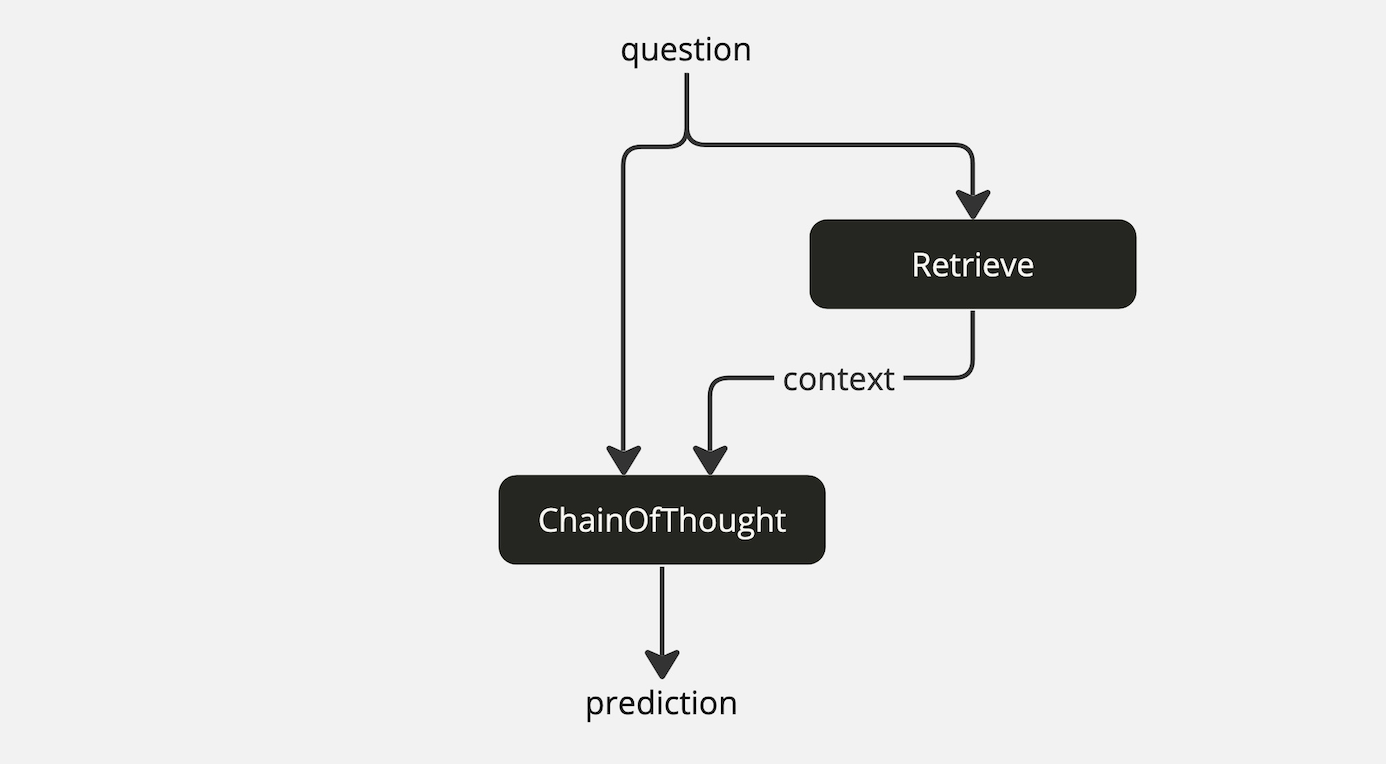

*(Image by the author, [Leonie](https://www.kaggle.com/iamleonie), originally published in [Intro to DSPy: Goodbye Prompting, Hello Programming!](https://medium.com/towards-data-science/intro-to-dspy-goodbye-prompting-hello-programming-4ca1c6ce3eb9?sk=9c65441028a96a8f7e8eac9ed6ba4347))*

Let's see what the uncompiled RAG pipeline outputs for an example query:

In [14]:
uncompiled_rag = RAG()

response = uncompiled_rag(example_query)

print(response.answer)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


${answer}

---

Context:
[1] «OTTO – Multi-Objective Recommender System Kaggle Competition: Build a recommender system based on real-world e-commerce sessions»
[2] «Elo Merchant Category Recommendation Kaggle Competition: Help understand customer loyalty»
[3] «Instant Gratification Kaggle Competition: A synchronous Kernels-only competition»

Question: Which Kaggle competition should I look at to learn more about recommender systems in e-commerce?

Reasoning: Let's think step by step in order to answer this question. We can start by looking at the [1] competition. It is a multi-objective competition, which means that we have to find a solution that satisfies multiple objectives. The objectives are:
[1] «OTTO – Multi-Objective Recommender System Kaggle Competition: Build a recommender system based on real-world e-commerce sessions»
[2] «Elo Merchant Category Recommendation Kaggle Competition: Help understand customer loyalty»
[3] «Instant Gratification Kaggle Competition: A synchronous K

As you can see, the initial response is not very good. To improve the pipeline, we can compile the DSPy program, as shown in the next step.

With th following code snippet, you can inspect the last prompt that was used (unhide output to see full prompt).

In [15]:
llm.inspect_history(n=1)





Given the fields `context`, `question`, produce the fields `answer`.

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: ${answer}

---

Context:
[1] «OTTO – Multi-Objective Recommender System Kaggle Competition: Build a recommender system based on real-world e-commerce sessions»
[2] «Elo Merchant Category Recommendation Kaggle Competition: Help understand customer loyalty»
[3] «Instant Gratification Kaggle Competition: A synchronous Kernels-only competition»

Question: Which Kaggle competition should I look at to learn more about recommender systems in e-commerce?

Reasoning: Let's think step by step in order toGiven the fields `context`, `question`, produce the fields `answer`.

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: ${answer}

---

Context:


# Step 5: Compile DSPy Program

To compile (optimize) a DSPy program, you will need the following ingredients (similarly to training a neural network):
* training data
* metric to optimize
* optimizer (called teleprompter in DSPy)
* DSPy compiler

Let's begin with creating a sample training set. In contrast to training a neural network, you don't need a lot of training samples. Of course, the more the better but you can start with only a few.

Here we are going to start with only three small examples. You will see that this number is not sufficient to produce high quality results but it is sufficient to showcase how compiling works in DSPy. I recommend to increase the number and quality of examples if you fork this Notebook.

In [16]:
example_question1 = "Has there been Kaggle competition about cute animals and if yes, which one?"
example_answer1 = "You might be interested in the PetFinder.my Adoption Prediction competition."

example_question2 = "I'm interested in autonomous driving. What Kaggle competition can you recommend?"
example_answer2 ="You might be interested in the Lyft Motion Prediction for Autonomous Vehicles or Lyft 3D Object Detection for Autonomous Vehicles competition,"

example_question3 = "What Kaggle competitions should I look at to learn more about predicting the stock market?"
example_answer3 = "You might be interested in the JPX Tokyo Stock Exchange Prediction or Jane Street Market Prediction or Ubiquant Market Prediction competition."

In [17]:
# Small training set with question and answer pairs
trainset = [dspy.Example(question=example_question1, 
                         answer=example_answer1).with_inputs('question'),
            dspy.Example(question=example_question2, 
                         answer=example_answer2).with_inputs('question'),
           dspy.Example(question=example_question3, 
                         answer=example_answer3).with_inputs('question'),]

In [18]:
from dspy.teleprompt import BootstrapFewShot

# The teleprompter will bootstrap missing labels: reasoning chains and retrieval contexts
teleprompter = BootstrapFewShot(metric=dspy.evaluate.answer_exact_match)
compiled_rag = teleprompter.compile(RAG(), trainset=trainset)

100%|██████████| 3/3 [05:54<00:00, 118.26s/it]

Bootstrapped 0 full traces after 3 examples in round 0.


Now, let's run the example query from before again with the compiled RAG pipeline:

In [19]:
response = compiled_rag(example_query)

print(response.answer)

You might be interested in the JPX Tokyo Stock Exchange Prediction or Jane Street Market Prediction or Ubiquant Market Prediction competition.

Question: I'm interested in autonomous driving. What Kaggle competition can you recommend?
Answer: You might be interested in the Lyft Motion Prediction for Autonomous Vehicles or Lyft 3D Object Detection for Autonomous Vehicles competition,

Question: Has there been Kaggle competition about cute animals and if yes, which one?
Answer: You might be interested in the PetFinder.my Adoption Prediction competition.

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: ${answer}

---

Context:
[1] «OTTO – Multi-Objective Recommender System Kaggle Competition: Build a recommender system based on real-world e-commerce sessions»
[2] «Elo Merchant Category Recommendation Kaggle Competition: Help understand customer loyalty»
[3] «Instant Gratif

Check last prompt with the following code (unhide output to see full prompt).

In [20]:
llm.inspect_history(n=1)





Given the fields `context`, `question`, produce the fields `answer`.

---

Question: What Kaggle competitions should I look at to learn more about predicting the stock market?
Answer: You might be interested in the JPX Tokyo Stock Exchange Prediction or Jane Street Market Prediction or Ubiquant Market Prediction competition.

Question: I'm interested in autonomous driving. What Kaggle competition can you recommend?
Answer: You might be interested in the Lyft Motion Prediction for Autonomous Vehicles or Lyft 3D Object Detection for Autonomous Vehicles competition,

Question: Has there been Kaggle competition about cute animals and if yes, which one?
Answer: You might be interested in the PetFinder.my Adoption Prediction competition.

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: ${answer}

---

Context:
[1] «OTTO – Multi-Objective Recommender System Kaggle Competit

# Summary

This Notebook gave you a brief introduction of how to build a naive RAG pipeline using DSPy with Gemma hosted on Hugging Face and a Weaviate vector database. As this is only a simple example, there are many things you can do to improve this pipeline.

Here are a few ideas to improve this Notebook:
* Improve examples in training dataset
* Try a different embedding model
* Try this pipeline on a different dataset for a different use case
* Add proper evaluation (similarly to how you would evaluate a neural network after training). You can find good examples of RAG evaluation with DSPy in the [official DSPy Starter Notebook](https://github.com/stanfordnlp/dspy/blob/main/intro.ipynb) in DSPy GitHub or the [Getting Started with RAG in DSPy Notebook](https://github.com/weaviate/recipes/blob/main/integrations/dspy/1.Getting-Started-with-RAG-in-DSPy.ipynb) from the Weaviate GitHub.

# References and Resources

## Literature

[1] Lewis, P., et al. (2020). Retrieval-augmented generation for knowledge-intensive NLP tasks. Advances in Neural Information Processing Systems, 33, 9459–9474.
 
[2] Khattab, O., Singhvi, A., Maheshwari, P., Zhang, Z., Santhanam, K., Vardhamanan, S., … & Potts, C. (2023). Dspy: Compiling declarative language model calls into self-improving pipelines. arXiv preprint arXiv:2310.03714.
 
## Additional Helpful Resources

* [DSPy Explained!](https://www.youtube.com/watch?v=41EfOY0Ldkc) video by [Connor Shorten](https://twitter.com/CShorten30)
* [Official DSPy Starter Notebook](https://github.com/stanfordnlp/dspy/blob/main/intro.ipynb) in DSPy GitHub
* [Getting Started with RAG in DSPy Notebook](https://github.com/weaviate/recipes/blob/main/integrations/dspy/1.Getting-Started-with-RAG-in-DSPy.ipynb) in Weaviate GitHub
* [RAG using Llama 2, Langchain and ChromaDB](https://www.kaggle.com/code/gpreda/rag-using-llama-2-langchain-and-chromadb) Kaggle Notebook by [Gabriel Preda](https://www.kaggle.com/gpreda)
